In [4]:
import ee
import os
# import eemont
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
ee.Initialize()
ee.Authenticate()


Successfully saved authorization token.


In [46]:
def getLandsat(start, end, region, useMask=True, targetBands=None, sensors=None):
    if targetBands == None: 
        targetBands = ['BLUE','GREEN','RED', 'NIR','SWIR1','SWIR2']
    if sensors == None:
        sensors = dict(l4=True, l5=True, l7=True, l8=True)
    collection8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start, end).filterBounds(region).preprocess().spectralIndices(VI_list).select(VI_list)
    collection7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
        .filterDate(start, end).filterBounds(region).preprocess().spectralIndices(VI_list).select(VI_list)
    collection5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
         .filterDate(start, end).filterBounds(region).preprocess().spectralIndices(VI_list).select(VI_list)
    col = collection5.merge(collection7).merge(collection8)
    return ee.ImageCollection(col)

def prepareL4L5(image):
    bandList = ['B1', 'B2','B3','B4','B5','B7','B6']
    scaling = [10000, 10000, 10000, 10000, 10000, 10000, 1000]
    scaled = ee.Image(image).select(bandList).divide(ee.Image.constant(scaling))
    validQA = [66, 130, 68, 132]
    mask1 = ee.Image(image).select(['pixel_qa']).remap(validQA, ee.List.repeat(1, len(validQA)), 0)
    mask2 = image.select('radsat_qa').eq(0)
    mask3 = image.select(bandList).reduce(ee.Reducer.min()).gt(0)
    mask4 = image.select("sr_atmos_opacity").unmask().lt(300)
    return ee.Image(image).addBands(scaled).updateMask(mask1.And(mask2).And(mask3).And(mask4))

def prepareL7(image):
    bandList = ['B1', 'B2','B3','B4','B5','B7','B6']
    scaling = [10000, 10000, 10000, 10000, 10000, 10000, 1000]
    scaled = ee.Image(image).select(bandList).divide(ee.Image.constant(scaling))
    validQA = [66, 130, 68, 132]
    mask1 = ee.Image(image).select(['pixel_qa']).remap(validQA, ee.List.repeat(1, len(validQA)), 0)
    mask2 = image.select('radsat_qa').eq(0)
    mask3 = image.select(bandList).reduce(ee.Reducer.min()).gt(0)
    mask4 = image.select("sr_atmos_opacity").unmask().lt(300)
    mask5 = ee.Image(image).mask().reduce(ee.Reducer.min()).focal_min(2.5)
    return ee.Image(image).addBands(scaled).updateMask(mask1.And(mask2).And(mask3).And(mask4).And(mask5))

def prepareL8(image):
    bandList = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10']
    scaling = [10000, 10000, 10000, 10000, 10000, 10000, 1000]
    validTOA = [66, 68, 72, 80, 96, 100, 130, 132, 136, 144, 160, 164]
    validQA = [322, 386, 324, 388, 836, 900]
    scaled = ee.Image(image).select(bandList).divide(ee.Image.constant(scaling))
    mask1 = ee.Image(image).select(['pixel_qa']).remap(validQA, ee.List.repeat(1, len(validQA)), 0)
    mask2 = image.select('radsat_qa').eq(0)
    mask3 = image.select(bandList).reduce(ee.Reducer.min()).gt(0)
    mask4 = ee.Image(image).select(['sr_aerosol']).remap(validTOA, ee.List.repeat(1, len(validQA)), 0)
    return ee.Image(image).addBands(scaled).updateMask(mask1.And(mask2).And(mask3).And(mask4))

def composite_by_month(imgCl, region, num_year, reducer, month_index=None):
    """ create composite based on month
        Note that the image should come from the same year!

        Parameters
        ----------
        imgCl: ee.imageCollection,
            the image collection to be composed
        region: ee.Geometry
            the region for the composition
        num_year: int
            the number of years for the composition
        reducer: ee.Reducer
            the way to reduce images within a single month
        
        Returns
        ----------
        ee.ImageCollection
            a collection containing all composed images
    """
    # determine the initial year 
    ini_year = imgCl.first().date().get('year')
    c = ee.List([])
    for y in range(num_year):
        # select images from a single year
        imgCl_subset = imgCl.filterDate(ee.Date.fromYMD(ini_year+y, 1, 1), ee.Date.fromYMD(ini_year+y+1, 1, 1))  
        # generate composite for each month
        if month_index == None:
            for i in range(12):
                # select images from a single month
                imgs = imgCl_subset.filterBounds(region).filter(ee.Filter.calendarRange(i, i+1, 'month'))
                if imgs.size().getInfo() != 0:
                    # assign the date of the last image within the interval as the 'system:time_start' to the composite
                    date_last = imgs.aggregate_array('system:time_start').reduce(ee.Reducer.last())
                    print (ee.Date(date_last).format().getInfo())
                    # assign the date appears most to the composite
                    date_mode = ee.Date(imgs.aggregate_array('system:time_start').reduce(ee.Reducer.mode())).format()
                    c = c.add(imgs.reduce(reducer)
                                    .clip(region) \
                                    .set({'system:time_start':date_last, 'date_mode': date_mode}))
        else:
            imgs = imgCl_subset.filterBounds(region).filter(ee.Filter.calendarRange(month_index[0], month_index[1], 'month'))
            if imgs.size().getInfo() != 0:
                # assign the date of the last image within the interval as the 'system:time_start' to the composite
                date_last = imgs.aggregate_array('system:time_start').reduce(ee.Reducer.last())
                print (ee.Date(date_last).format().getInfo())
                # assign the date appears most to the composite
                date_mode = ee.Date(imgs.aggregate_array('system:time_start').reduce(ee.Reducer.mode())).format()
                c = c.add(imgs.reduce(reducer)
                                .clip(region) \
                                .set({'system:time_start':date_last, 'date_mode': date_mode}))
    return ee.ImageCollection(c)

In [47]:
global VI_list
VI_list = ['NDVI', 'EVI', 'EVI2', 'SAVI', 'WDRVI']
cities = ee.FeatureCollection('users/lin00370/Morocco/irrigation/cities')
gt = ee.FeatureCollection("users/lin00370/Morocco/ground_truth_rachid")
# rainfed = ee.FeatureCollection('users/lin00370/Morocco/irrigation/rainfed')
# irrigated = ee.FeatureCollection('users/lin00370/Morocco/irrigation/irrigated')
irrigated = gt.filterMetadata("Tree_type", "equals", "olive")\
                            .filterMetadata("Irrigation", "equals", "irrigated")
rainfed = gt.filterMetadata("Tree_type", "equals", "olive")\
                            .filterMetadata("Irrigation", "equals", "rainfed")
study_area = ee.FeatureCollection('users/lin00370/Morocco/indiTree/study_region')

ls = getLandsat('2020-01-01', '2023-01-01', study_area)
composite_ls = composite_by_month(ls, study_area, 3, ee.Reducer.max(), [1, 13])
# ERA5 = ee.ImageCollection("ECMWF/ERA5/DAILY") \
#          .filterDate('2000-01-01', '2021-01-01',) \
#          .select(['total_precipitation'])
# composite_ERA5 = composite_by_month(ERA5, study_area, 20, ee.Reducer.sum(), [1, 13])

2020-12-27T10:57:52
2021-12-30T10:57:49
2022-12-17T10:58:01


In [84]:
composite_ls = ee.Image("users/lin00370/Morocco/irrigation/ts_ndvi")
VI_list = ['NDVI']
# for n in range(4):
    # ts_vi_irri = composite_ls.getTimeSeriesByRegion(reducer = ee.Reducer.mean(),
    #                                                 geometry = ee.Feature(irrigated.toList(10).get(n)),
    #                                                 scale = 30)

ts_vi_irri = composite_ls.reduceRegions(collection=irrigated, reducer=ee.Reducer.mean(), scale=30)
export_irri = ee.batch.Export.table.toDrive(\
                collection=ts_vi_irri, \
                description="ndvi_irri2", \
                folder='annual', \
                selectors=['FIELD_ID']+[f'year_{i}' for i in range(2000, 2023)] + ["Irrigation", "Irrigati_1", "Tree_type", "Age"])

ts_vi_rf = composite_ls.reduceRegions(collection=rainfed, reducer=ee.Reducer.mean(), scale=30)
export_rf = ee.batch.Export.table.toDrive(\
                collection=ts_vi_rf, \
                description="ndvi_rf2", \
                folder='annual', \
                 selectors=['FIELD_ID']+[f'year_{i}' for i in range(2000, 2023)] + ["Irrigation", "Irrigati_1", "Tree_type", "Age"])

export_irri.start()
export_rf.start()


In [25]:
composite_ERA5 = composite_ERA5.toBands().rename([f'year_{i}' for i in range(2000, 2020)])

In [30]:

ts_prcp_irri = composite_ERA5.reduceRegions(reducer = ee.Reducer.mean(),
                                                     collection = irrigated,
                                                     scale = 30)
export_irri = ee.batch.Export.table.toDrive(\
                collection=ts_prcp_irri, \
                description="prcp_irri", \
                folder='annual', \
                selectors=['FIELD_ID']+[f'year_{i}' for i in range(2000, 2020)])

ts_prcp_rf = composite_ERA5.reduceRegions(reducer = ee.Reducer.mean(),
                                            collection = rainfed,
                                                scale = 30)
export_rf = ee.batch.Export.table.toDrive(\
                collection=ts_prcp_rf, \
                description="prcp_rf", \
                folder='annual', \
                selectors=['FIELD_ID']+[f'year_{i}' for i in range(2000, 2020)])

export_irri.start()
export_rf.start()

['year_2000', 'year_2001', 'year_2002', 'year_2003', 'year_2004', 'year_2005', 'year_2006', 'year_2007', 'year_2008', 'year_2009', 'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015', 'year_2016', 'year_2017', 'year_2018', 'year_2019', 'Status', 'Tree_type', 'Irrigation', 'Zone', 'FIELD_ID', 'Other_Obs', 'Irrigati_1', 'ID_1', 'ID', 'Zone_1', 'Age', 'system:index', 'height']


In [5]:
def set_plot_ticks(ax, font='Arial', style='normal', size=20, weight='normal', x_rot=0, y_rot=0):
    '''
    --- this function is used to set properties of x/y label ticks, including fonts, size, weight, rotation, etc.
    --- argument:
        --- ax: matplotlib.axes, the current axes object
    '''
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    for label in labels:
        label.set_fontname(font)
        label.set_style(style)
        label.set_fontsize(size)
        label.set_weight(weight)
        label.set_color('k')
    for l_x in ax.get_xticklabels():
        l_x.set_rotation(x_rot)
    for l_y in ax.get_yticklabels():
        l_y.set_rotation(y_rot)
site_rachid = ['Fes', 'Fes-Nord', 'GUERSIF', 'Ribat Al Khyr', 'Sefrou', 'TAOUNATE', 'Tahla', 'Taza']
site_name_conversion = {
    "Fes" : "Fes",
    "Fes-Nord": "Karia Be Mohammed",
    "GUERSIF": "Guercif",
    "Ribat Al Khyr": "Ahermoumou",
    "Sefrou": "Sefrou",
    "TAOUNATE": "Taounate",
    "Tahla": "Tahala",
    "Taza": "Taza"
}
root_dir = r"G:\My Drive\Digital_Agriculture\Morocco\entire_region\irrigation\gee_irrigation\annual"
vi_irri = pd.read_csv(os.path.join(root_dir, 'ndvi_irri2.csv'))
vi_rf = pd.read_csv(os.path.join(root_dir, 'ndvi_rf2.csv'))
prcp_irri = pd.read_csv(os.path.join(root_dir, 'prcp_irri.csv'))
prcp_rf = pd.read_csv(os.path.join(root_dir, 'prcp_rf.csv'))
df = pd.DataFrame(data=[], columns=['vi_irri', "vi_rf", "prcp_irri", "prcp_rf"])
np.random.seed(1000)
n_site = 2000
n_irri = np.random.choice(len(vi_irri), n_site)
n_rf = np.random.choice(len(vi_rf), n_site)
mask1 = np.logical_or(vi_irri["Irrigati_1"]=="surface", vi_irri["Irrigati_1"]=="sc")
mask2 = vi_irri["Irrigati_1"]=="drip"
vi_irri.drop(["FIELD_ID", "Irrigation", "Irrigati_1"] + [f"year_{y}" for y in range(2000, 2009)], axis=1)[mask1].describe()

# for i in range(n_site):
#     if i == 0:
#         df["vi_irri"] = vi_irri.drop("FIELD_ID", axis=1).loc[n_irri[i]]
#         df["vi_rf"] = vi_rf.drop("FIELD_ID", axis=1).loc[n_rf[i]]
#         df["prcp_irri"] = prcp_irri.drop("FIELD_ID", axis=1).loc[n_irri[i]] * 1000
#         df["prcp_rf"] = prcp_rf.drop("FIELD_ID", axis=1).loc[n_rf[i]] * 1000
#     else:
#         new_df = pd.DataFrame(data=[], columns=['vi_irri', "vi_rf", "prcp_irri", "prcp_rf"])
#         new_df["vi_irri"] = vi_irri.drop("FIELD_ID", axis=1).loc[n_irri[i]]
#         new_df["vi_rf"] = vi_rf.drop("FIELD_ID", axis=1).loc[n_rf[i]]
#         new_df["prcp_irri"] = prcp_irri.drop("FIELD_ID", axis=1).loc[n_irri[i]] * 1000
#         new_df["prcp_rf"] = prcp_rf.drop("FIELD_ID", axis=1).loc[n_rf[i]] * 1000
#         df = df.append(new_df, ignore_index=True)
# print (df.mean(), df.std())

,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,Age
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,0.316215,0.328169,0.321039,0.319614,0.364986,0.373542,0.363180,0.380461,0.371574,0.417151,0.397172,0.387445,0.396426,0.383863,13.857143
std,0.115972,0.117270,0.122929,0.120504,0.125254,0.124341,0.116571,0.115904,0.102880,0.113783,0.103293,0.090492,0.081530,0.086757,20.127703
min,0.107894,0.118774,0.093008,0.077795,0.099203,0.098231,0.097308,0.101143,0.113647,0.156357,0.141933,0.146099,0.147619,0.154957,0.000000
25%,0.219996,0.216201,0.218104,0.220892,0.261049,0.266319,0.268286,0.303371,0.303412,0.335353,0.333305,0.349642,0.364140,0.330688,0.000000
50%,0.340702,0.358393,0.353064,0.338199,0.371776,0.394052,0.356966,0.383951,0.364039,0.435843,0.410588,0.397928,0.401573,0.396932,0.000000
75%,0.409168,0.418959,0.426824,0.421278,0.484785,0.486183,0.467887,0.492288,0.461284,0.511433,0.471716,0.461221,0.456040,0.452203,32.500000
max,0.540497,0.534167,0.517769,0.508476,0.607583,0.595455,0.589745,0.583837,0.534926,0.597152,0.548586,0.517600,0.542655,0.550991,70.000000


In [26]:
prcp_irri.describe()

,year_2000,year_2001,year_2002,year_2003,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019
count,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000
mean,0.340468,0.265157,0.424023,0.490174,0.315539,0.228710,0.354328,0.337762,0.472285,0.410677,0.640674,0.399622,0.370411,0.429760,0.337555,0.330057,0.361694,0.226920,0.503046,0.284110
std,0.178528,0.140503,0.178963,0.241536,0.142493,0.094392,0.157289,0.098191,0.161323,0.296728,0.359766,0.201218,0.193407,0.237866,0.220833,0.100751,0.173117,0.139070,0.302691,0.166404
min,0.191004,0.144743,0.271950,0.280388,0.197874,0.140679,0.209497,0.245830,0.331658,0.170512,0.351729,0.221446,0.204939,0.238512,0.147269,0.233087,0.220575,0.101151,0.250615,0.147267
25%,0.191004,0.144743,0.271950,0.280388,0.197874,0.140679,0.209497,0.245830,0.331658,0.170512,0.351729,0.221446,0.204939,0.238512,0.147269,0.233087,0.220575,0.101151,0.250615,0.147267
50%,0.286153,0.232532,0.369566,0.409482,0.260641,0.222165,0.327022,0.322145,0.449077,0.290676,0.520964,0.346824,0.301248,0.338560,0.261961,0.333142,0.291796,0.187721,0.391884,0.216167
75%,0.475243,0.367284,0.583630,0.754258,0.449252,0.346579,0.520178,0.458525,0.617666,0.658620,0.877469,0.660484,0.589794,0.596036,0.532720,0.424746,0.499371,0.372910,0.739543,0.405642
max,0.774188,0.639643,0.855720,1.006383,0.670959,0.414902,0.649664,0.561637,0.888111,1.169924,1.657123,0.785671,0.783792,1.030650,0.802327,0.512515,0.799339,0.498953,1.249205,0.718731


#### T-test

In [19]:
# filtered_vi_irri = vi_irri[vi_irri["Tree_type"]=="olive"].drop(drop_lst, axis=1).to_numpy()
filtered_vi_irri = vi_irri[np.logical_or(vi_irri["Irrigati_1"]=="surface", vi_irri["Irrigati_1"]=="sc")].drop(drop_lst, axis=1).to_numpy()
filtered_vi_rf = vi_irri[vi_irri["Irrigati_1"]=="drip"].drop(drop_lst, axis=1).to_numpy()
mean_irri = np.mean(filtered_vi_irri, axis=0)
mean_rf = np.mean(filtered_vi_rf, axis=0)
mean_mean_irri = np.mean(mean_irri)
mean_mean_rf = np.mean(mean_rf)
std_mean_irri = np.std(mean_irri)
std_mean_rf = np.std(mean_rf)
t = (mean_mean_irri - mean_mean_rf) / np.sqrt((std_mean_irri ** 2 + std_mean_rf ** 2) / 14)
t

7.647709531483896

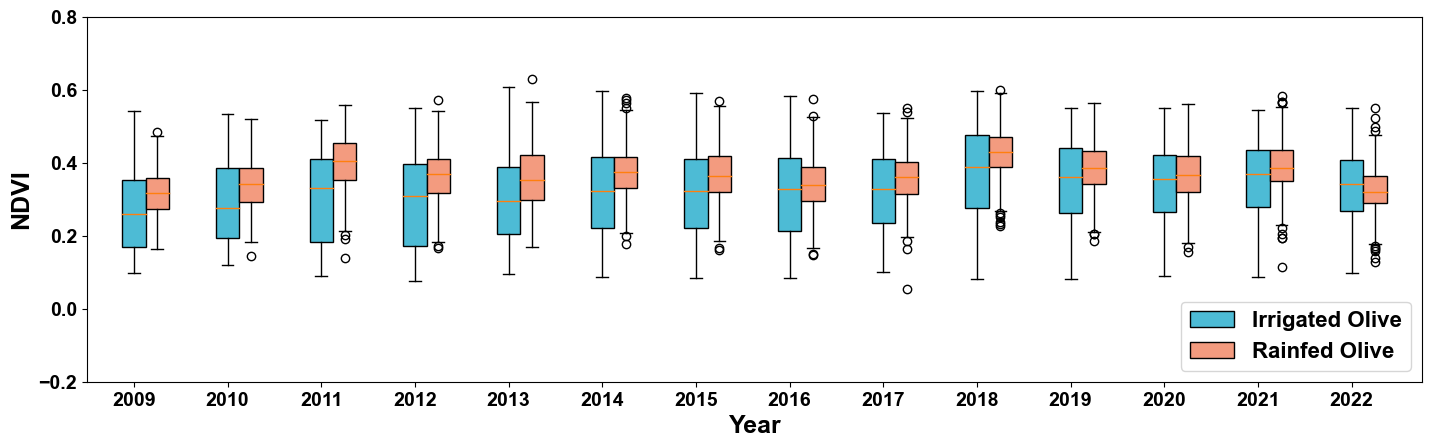

In [7]:
c = np.array([[230, 75, 53], [77, 187, 213],
     [0, 160, 135], [60, 84, 136],
     [243, 155, 127], [132, 145, 180],
     [145, 209, 194], [126, 97, 72]]) / 255.0
fig = plt.figure(figsize=(15, 5))
drop_lst = ["FIELD_ID", "Irrigation", "Irrigati_1", "Tree_type", "Age"] + [f"year_{y}" for y in range(2000, 2009)]
bp_irri = plt.boxplot(vi_irri[vi_irri["Tree_type"]=="olive"].drop(drop_lst, axis=1).to_numpy(), 
            positions=np.arange(0.875, 14.875, 1), widths=0.25,
            patch_artist = True)
for patch in bp_irri['boxes']:
     patch.set_facecolor(c[1])
bp_rf = plt.boxplot(vi_rf[vi_rf["Tree_type"]=="olive"].drop(drop_lst, axis=1).to_numpy(),
            positions=np.arange(1.125, 15.125, 1), widths=0.25,
            patch_artist=True)
for patch in bp_rf['boxes']:
     patch.set_facecolor(c[4]) 
plt.ylim(-0.2, 0.8)
plt.xticks(np.arange(0.875, 14.125, 1), range(2009, 2023))
set_plot_ticks(plt.gca(), size=14, weight='bold')        
plt.gca().set_facecolor("w")
plt.xlabel("Year", fontdict={'family':"Arial", "size":18, "weight":"bold"})
plt.ylabel("NDVI", fontdict={'family':"Arial", "size":18, "weight":"bold"})
plt.subplots_adjust(left=0.06, bottom=0.15, right=0.95)
plt.gca().legend([bp_irri["boxes"][0], bp_rf["boxes"][0]], ['Irrigated Olive', 'Rainfed Olive'], loc=4,  prop={"family":"Arial", "size":16, "weight":"bold"})
# plt.show()
# plt.savefig(rf'G:\My Drive\Digital_Agriculture\Morocco\entire_region\manuscript\figures\ndvi_dif.jpg')

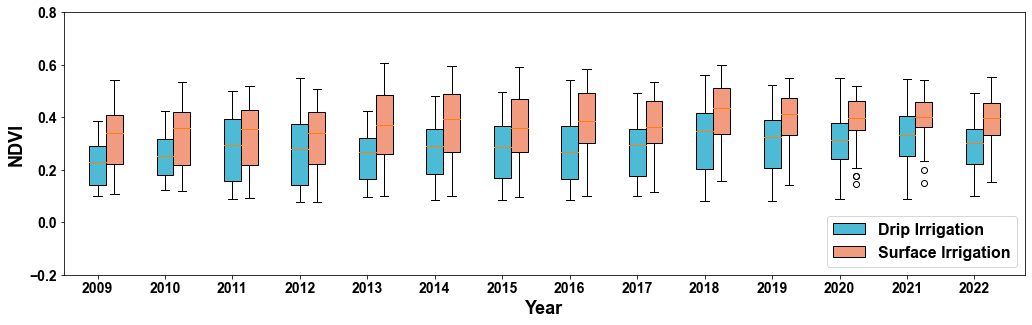

In [91]:
c = np.array([[230, 75, 53], [77, 187, 213],
     [0, 160, 135], [60, 84, 136],
     [243, 155, 127], [132, 145, 180],
     [145, 209, 194], [126, 97, 72]]) / 255.0
fig = plt.figure(figsize=(15, 5))
drip = vi_irri[vi_irri["Irrigati_1"]=="drip"].drop(drop_lst, axis=1)
bp_drip = plt.boxplot(drip,
            positions=np.arange(0.875, 14.875, 1), widths=0.25, patch_artist=True)
for patch in bp_drip['boxes']:
     patch.set_facecolor(c[1])
bp_surface = plt.boxplot(vi_irri[np.logical_or(vi_irri["Irrigati_1"]=="surface", vi_irri["Irrigati_1"]=="sc")].drop(drop_lst, axis=1).to_numpy(),
            positions=np.arange(1.125, 15.125, 1), widths=0.25, patch_artist=True)
for patch in bp_surface['boxes']:
     patch.set_facecolor(c[4])
plt.ylim(-0.2, 0.8)
plt.xticks(np.arange(0.875, 14.125, 1), range(2009, 2023))
set_plot_ticks(plt.gca(), size=14, weight='bold')        
plt.gca().set_facecolor("w")
plt.xlabel("Year", fontdict={'family':"Arial", "size":18, "weight":"bold"})
plt.ylabel("NDVI", fontdict={'family':"Arial", "size":18, "weight":"bold"})
plt.subplots_adjust(left=0.06, bottom=0.15, right=0.95)
plt.gca().legend([bp_irri["boxes"][0], bp_rf["boxes"][0]], ['Drip Irrigation', 'Surface Irrigation'], loc=4,  prop={"family":"Arial", "size":16, "weight":"bold"})
# plt.show()
plt.savefig(rf'G:\My Drive\Digital_Agriculture\Morocco\entire_region\manuscript\figures\irri_dif.jpg')

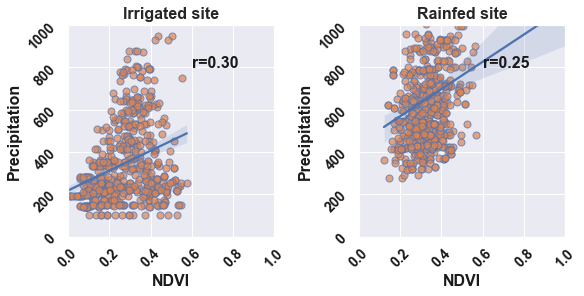

In [115]:
import seaborn as sns
import scipy as sp
fig, ax =plt.subplots(1, 2, constrained_layout=True, figsize=(8, 4))
sns.set_theme(color_codes=True) 
r, p = sp.stats.pearsonr(df['vi_irri'], df['prcp_irri'])
sns.regplot(data=df, x='vi_irri', y='prcp_irri', ax=ax[0], marker='o', \
                scatter_kws=dict(s=50, alpha=0.7, edgecolor='C0', color='C1'))
ax[0].set_xlabel('NDVI', font=dict(size=16, weight='bold'), c='k')
ax[0].set_ylabel('Precipitation', font=dict(size=16, weight='bold'), c='k')
ax[0].set_title('Irrigated site', font=dict(size=16, weight='bold', family='Arial'))
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1000)
ax[0].text(0.6, 800, 'r={:.2f}'.format(r), font=dict(size=16, weight='bold', family='Arial'), c='k')
set_plot_ticks(ax[0], size=14, weight='bold',  x_rot=45, y_rot=45)
r, p = sp.stats.pearsonr(df['vi_rf'], df['prcp_rf'])
sns.regplot(data=df, x='vi_rf', y='prcp_rf', ax=ax[1], marker='o', \
                scatter_kws=dict(s=50, alpha=0.7, edgecolor='C0', color='C1'))
ax[1].set_xlabel('NDVI', font=dict(size=16, weight='bold'), c='k')
ax[1].set_ylabel('Precipitation', font=dict(size=16, weight='bold'), c='k')
ax[1].set_title('Rainfed site', font=dict(size=16, weight='bold', family='Arial'))
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1000)
ax[1].text(0.6, 800, 'r={:.2f}'.format(r), font=dict(size=16, weight='bold', family='Arial'), c='k')
set_plot_ticks(ax[1], size=14, weight='bold',  x_rot=45, y_rot=45)
ax.legend(loc=4, prop={"family":"Arial", "size":18, "weight":"bold"})
plt.show()
# plt.savefig(r'G:\My Drive\Digital_Agriculture\Morocco\NASA_LULUC\irrigated_vs_rainfed.jpg')

In [2]:
import zipfile
import os
root_dir = r"Z:\Morocco\second_data\raw"
for item in os.listdir(root_dir):
    with zipfile.ZipFile(os.path.join(root_dir, item), 'r') as zip_ref:
        zip_ref.extractall(root_dir.replace("raw", "unzip")+"\\" + item.replace(".zip", ""))